<center><h1> Full-Body Tracking Using OpenPose </h1>


<h3> James Trujillo ( james.trujillo@donders.ru.nl )<br>Wim Pouw ( wim.pouw@donders.ru.nl )<br>
    18-11-2021 </h3>
    
<img src="./images/envision_banner.png"> </center>

<h3> Info documents </h3>
This module demonstrates an alternative full-body tracking approach called OpenPose. We provide code for running the motion tracking using OpenPose, and discuss how it compares to MediaPipe.
<br><br>

* OpenPose citation:
Z. Cao, G. Hidalgo, T. Simon, S. -E. Wei and Y. Sheikh, "OpenPose: Realtime Multi-Person 2D Pose Estimation Using Part Affinity Fields," in <i>IEEE Transactions on Pattern Analysis and Machine Intelligence</i>, vol. 43, no. 1, pp. 172-186, 1 Jan. 2021, doi: 10.1109/TPAMI.2019.2929257.
<br>DOI: 10.1109/TPAMI.2019.2929257 <br>

* location code: 
https://osf.io/rxb8j/
<i>ALL_MATERIALS_DOWNLOAD_V1.rar</i>

* citation: 
Trujillo, J.P. & Pouw, W.  (2021-11-18). <i> Full-Body Tracking Using OpenPose </i> \[day you visited the site]. Retrieved from: https://github.com/WimPouw/EnvisionBootcamp2021/tree/main/Python/MediaBodyTracking 


<h3> Introduction </h3>
OpenPose provides another method of performing motion tracking of video or image data. While it's not as lightweight as MediaPipe, it has the option of running it on a GPU (faster method, but requires a more powerful computer) or on a CPU (more accessible, but much slower). In this module, we won't go into details regarding installation or any in-depth OpenPose code per se. Instead, we will provide an overview of how OpenPose compares, and provide links to resources where you <i>can</i> learn more about getting started, performing tracking, etc. <br>
In general, if you visit our OSF project linked above and download the materials, you'll find some instructions on how to get things running in the <i>Instructions.txt</i> file. <br>
<h3> Running OpenPose </h3>
For this module, we stick to using the off-the-shelf OpenPoseDemo.exe program provided on the OpenPose GitHub page. This simple program can still be run in customizable ways depending on yours needs. For example, you can adjust the speed-precision trade-off, determine whether or not you want detailed hand tracking, and whether you want an output file with the keypoints drawn on. As part of the OSF resource linked above, we created a bash script that runs through a particular folder and runs OpenPose on each video it finds, saving the output data in a separate directory. Below you see the code for this bash script, which is available in the OSF link above, as OpenPose_loop.sh

The first bit of the script is just getting the list of files that it needs to process, and then creating variable names for its output files and directors. Then we actually run the analysis in this line:<br>
<i>bin/OpenPoseDemo.exe --video \\$file_new --hand --write_json \\$output_json_folder --write_video \\$output_video_filename</i>
<br>There are a couple of things we can customize here. <br>

* Removing the <i>--hand</i> flag removes tracking of the individual fingers, and also speeds up tracking perforamance
* Removing the <i>--write_video</i> flag and <i>//$output_video_filename</i> ensures no video file is created. We recommend keeping this in as an easy way to check tracking quality
* You can add a flag to reduce the quality of tracking in order to speed up the process. This may be desirable when processing large corpora which would otherwise have unfeasibly long processing times. Of course, you should then be extra sure that this reduction still results in accurate tracking. In order to do this you can add the flag <i>--net_resolution "320x176"</i><br>
<h3>Output</h3>
In contrast to the 3D coordinates provided by MediaPipe, OpenPose only provides 2D coordinates. These are given in pixels. This again can make it difficult to compare videos that were recorded from different viewpoints or distances from the subjects.<br>
However, OpenPose has the advantage that it can track full bodies, including the hands, from multiple participants at once. <br>
<img src="./images/pose_face_hands.gif"> </center> (image from https://github.com/CMU-Perceptual-Computing-Lab/openpose ) <br><br>
This makes OpenPose a useful solution to interaction-focused projects where multiple participants are in view, and where some overlap makes it difficult to separate the video into single-subject views.<br>
Note that you will then need to link tracked bodies from frame to frame. This is simply because OpenPose sometimes has tracking errors (like any video-based tracker) where an 'extra' body is detected, or one of the actual individuals is missing, making the ordering of individuals in your output data reliable <i>most</i> of the time, but not always.<br>
Below, we provide some python code for extracting the coordinates from the .json files that OpenPose provides, converting them into a dataframe, and ensuring that we are consistent with our ordering of subjects. This is useful, for example, if you have two individuals interacting with one another, and you want to extract a dataframe of participant A, and a dataframe of participant B.

In [2]:
"""
Imports the json files and collects seperate variables for each joint of interest.
These are used for subsequent Analyze script, and are also saved for data inspection.

Output: Velocity vectors for each hand; tracking-confidence for each hand; velocity & confidence plots


Created on Tue Jan 29 16:01:29 2019
@author: James Trujillo
"""

import os
import json
import matplotlib.pyplot as plt
import math
import csv
import numpy as np
import json
import pandas as pd

def import_json_data(vid_path):
    FPS = 25

    if os.path.isdir(vid_path):

        files = os.listdir(vid_path)
        R_Hand = []
        L_Hand = []
        Nose = []
        Neck = []
        MidHip = []
        REye = []
        LEye = []
        LElb = []
        RElb = []
        LHip = []
        RHip = []
        LEar = []
        REar = []


        valid_num = 0  # marker for most recent valid file. Used for exception handling
        ref = 1500
        for num, file in enumerate(files):
            miss_data = 0

            if file.endswith(".json"):
                filename = vid_path + '\\' + file

                # load the data. keypoints are given as x,y,confidence

                try:
                    with open(filename, 'r') as f:
                        datastore = json.load(f)
                        valid_num = num
                # if the .json is empty, re-use the previous one
                except:
                    if num > 1:
                        with open(vid_path + '\\' + files[valid_num], 'r') as f:
                            datastore = json.load(f)
                    else:
                        miss_data = 1
                        break
                reload = False              
                
                person_num = 0 # you can dynamically set this if there are multiple people in frame

                # store the Hand Points
                x = datastore["people"][person_num]["pose_keypoints_2d"][4 * 3]  
                y = datastore["people"][person_num]["pose_keypoints_2d"][(4 * 3) + 1]
                R_Hand.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][7 * 3]
                y = datastore["people"][person_num]["pose_keypoints_2d"][(7 * 3) + 1]
                L_Hand.append([x, y])
                # store body points
                x = datastore["people"][person_num]["pose_keypoints_2d"][0]  # 0 = Nose
                y = datastore["people"][person_num]["pose_keypoints_2d"][(0) + 1]
                Nose.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][1 * 3]  # 1 = Neck (Mid shoulder)
                y = datastore["people"][person_num]["pose_keypoints_2d"][(1 * 3) + 1]
                Neck.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][8 * 3]  # 8 = Mid Hip
                y = datastore["people"][person_num]["pose_keypoints_2d"][(8 * 3) + 1]
                MidHip.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][15 * 3]  # 15 = REye
                y = datastore["people"][person_num]["pose_keypoints_2d"][(15 * 3) + 1]
                REye.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][16 * 3]  # 16 = LEye
                y = datastore["people"][person_num]["pose_keypoints_2d"][(16 * 3) + 1]
                LEye.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][3 * 3]  # 3 = RElb
                y = datastore["people"][person_num]["pose_keypoints_2d"][(3 * 3) + 1]
                RElb.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][6 * 3]  # 6 = LElb
                y = datastore["people"][person_num]["pose_keypoints_2d"][(6 * 3) + 1]
                LElb.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][12 * 3]  # 12 = LHip
                y = datastore["people"][person_num]["pose_keypoints_2d"][(12 * 3) + 1]
                LHip.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][9 * 3]  # 9 = RHip
                y = datastore["people"][person_num]["pose_keypoints_2d"][(9 * 3) + 1]
                RHip.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][18 * 3]  # 18 = LEar
                y = datastore["people"][person_num]["pose_keypoints_2d"][(18 * 3) + 1]
                LEar.append([x, y])
                x = datastore["people"][person_num]["pose_keypoints_2d"][17 * 3]  # 17 = REar
                y = datastore["people"][person_num]["pose_keypoints_2d"][(17 * 3) + 1]
                REar.append([x, y])
                
                prev_file = datastore
                prev_hip_x = datastore["people"][person_num]["pose_keypoints_2d"][8 * 3]
            
        # make a dataframe
        df = pd.DataFrame(list(zip( R_Hand, L_Hand,Nose, Neck, MidHip, REye, LEye,
                                   RElb, LElb,LHip, RHip)),
                          columns=[ 'R_Hand','L_Hand','Nose', 'Neck', 'MidHip', 'REye', 'LEye',
                                   'RElb', 'LElb', 'LHip', 'RHip'])
        return df


def calculate_distance(Hand, FPS):
    """
    This just calculates the displacement between each set of points, then the
    velocity from the displacement.
    """
    IDX = 0
    dist = []
    vel = []
    for coords in Hand[1:]:
        Prev_coords = Hand[IDX]
        # first calculate displacement
        DISPLACE = math.hypot(float(coords[0]) - float(Prev_coords[0]), float(coords[1]) - float(Prev_coords[1]))
        dist.append(DISPLACE)
        # then calculate velocity
        vel.append(DISPLACE * FPS)
    return (dist, vel)


def write_data_to_file(data, filename, path):
    fullfile = path + filename
    output_array = np.array(data)
    np.savetxt(fullfile, output_array, delimiter="\t")


def make_vel_conf_plots(data_L, data_R, conf_L, conf_R, source, path):
    plt.figure(figsize=(20, 10))

    # Right affector velocity
    plt.subplot(2, 2, 1)
    plt.plot(data_R)

    plt.xlabel('frame', fontsize=20)
    plt.ylabel('velocity (px per s)', fontsize=20)
    plt.title(('Right ' + source + ' velocity'), fontsize=24)

    # Right affector confidence
    plt.subplot(2, 2, 2)
    plt.plot(conf_R)

    plt.xlabel('frame', fontsize=20)
    plt.ylabel('confidence', fontsize=20)
    plt.title(('Right ' + source + ' confidence'), fontsize=24)

    # Left affector velocity
    plt.subplot(2, 2, 3)
    plt.plot(data_L)

    plt.xlabel('frame', fontsize=20)
    plt.ylabel('velocity (px per s)', fontsize=20)
    plt.title(('Left ' + source + ' velocity'), fontsize=24)

    # left affector confidence
    plt.subplot(2, 2, 4)
    plt.plot(conf_L)

    plt.xlabel('frame', fontsize=20)
    plt.ylabel('confidence', fontsize=20)
    plt.title(('Left ' + source + ' confidence'), fontsize=24)

    plt.subplots_adjust(hspace=0.7)

    figname = path + '\\velocity_profile_' + source + '.png'
    plt.savefig(figname)

    plt.gcf().clear()
    plt.close()



You can run this function with a variable number of arguments, providing the directory where all of the .json files are stored (1st argument), a first and last frame if you want to extract data from a specific annotation, for instance (2nd and 3rd argument), tell it whether or not you want it to smooth the data (4th argument - True or False), and whether or not it should save the resulting dataframe (5th argument).<br>
This provides a dataframe output where we have an x,y pair for each keypoint. Note that the above code can of course include more keypoints in the dataframe, depending on what you are interested in working with

In [3]:
body_vid_path = "./Timeseries_Output/data/"
OP_body = import_json_data(body_vid_path)
OP_body.head()

,R_Hand,L_Hand,Nose,Neck,MidHip,REye,LEye,RElb,LElb,LHip,RHip
0,"[420, 712.084]","[753.128, 712.078]","[600.752, 214.451]","[596.832, 354.238]","[604.905, 712.066]","[572.096, 189.772]","[613.285, 185.679]","[415.794, 555.689]","[769.465, 543.369]","[679.042, 712.09]","[522.725, 712.067]"
1,"[420.015, 712.085]","[753.168, 712.082]","[600.752, 214.46]","[596.835, 354.227]","[604.925, 712.066]","[572.095, 189.775]","[613.283, 185.686]","[415.798, 555.627]","[769.444, 543.45]","[679.055, 712.091]","[522.75, 712.067]"
2,"[420.047, 712.086]","[757.141, 712.082]","[596.89, 214.453]","[596.84, 354.246]","[604.955, 712.067]","[572.089, 189.775]","[613.262, 185.674]","[415.787, 555.679]","[769.448, 543.474]","[679.085, 712.092]","[522.766, 712.068]"
3,"[420.044, 712.086]","[757.174, 712.084]","[596.884, 214.446]","[596.842, 354.247]","[604.926, 712.068]","[572.087, 189.768]","[613.243, 185.677]","[415.815, 555.653]","[769.442, 543.512]","[679.072, 712.093]","[518.758, 712.067]"
4,"[424.031, 712.087]","[757.232, 712.082]","[596.895, 214.443]","[596.816, 354.224]","[604.933, 712.067]","[572.091, 189.775]","[613.24, 185.666]","[415.823, 555.676]","[769.443, 543.519]","[679.089, 712.092]","[522.753, 712.067]"


Let's take a look at the velocity profile of the right hand. 

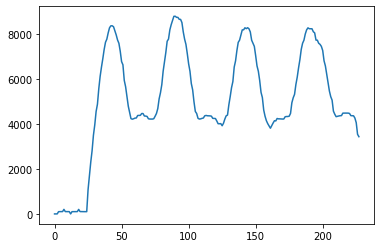

In [4]:
_,R_hand_vel = calculate_distance(OP_body["R_Hand"],25)
plt.plot(R_hand_vel)

We see the nice rhythmic "accordion motion", so that's great! <br>
Now how does this compare to MediaPipe, if we just look at these rather broad movement profiles of the two?


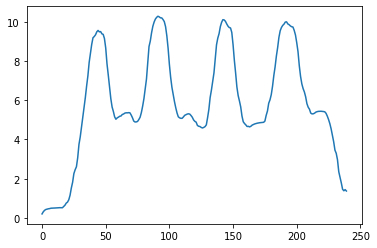

In [5]:
MP_body = pd.read_csv("./Timeseries_Output/ACCORDION_silentgesture_MP.csv")
MP_body.head()

# combine the x and y values to match the function input format
MP_wrist = [[row["X_RIGHT_WRIST"], row["Y_RIGHT_WRIST"]] for _,row in MP_body.iterrows()]
_,R_hand_vel_MP = calculate_distance(MP_wrist, 25)

plt.plot(R_hand_vel_MP)


To really compare the time courses, we should plot them together. Currently though, they're on different scales. An easy fix is to normalize the data.

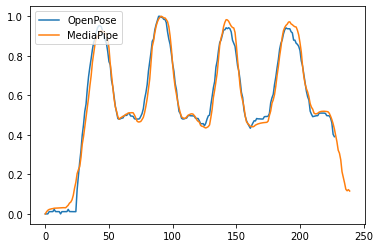

In [6]:
R_hand_vel_OP_n = (R_hand_vel - np.min(R_hand_vel)) / (np.max(R_hand_vel) - np.min(R_hand_vel))
R_hand_vel_MP_n = (R_hand_vel_MP - np.min(R_hand_vel_MP)) / (np.max(R_hand_vel_MP) - np.min(R_hand_vel_MP))

plt.plot(R_hand_vel_OP_n, label="OpenPose")
plt.plot(R_hand_vel_MP_n, label="MediaPipe")
plt.legend(loc="upper left")

We can see that the two time-series are very similar, with only minor divergences. We can therefore assume, at least given quality video recordings, the two tracking programs will provide similar quality output. <br>
MediaPipe therefore excels in terms of tracking speed, although OpenPose is still useful for situations where we have multiple people in frame simultaneously. 